In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn # to remove warnings

import pandas as pd, numpy as np, matplotlib.pyplot as plt
% matplotlib notebook

# Scoring: multi-class classification accuracy

In [2]:
original_data = pd.read_csv ('train.csv')
final_test_set = pd.read_csv ('test.csv') 
'''
The target values aren't given (they're on the Kaggle Website), 
so the final_test_set is not used to check for overfitting.
'''
original_data.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [3]:
original_data.shape

(15120, 56)

In [4]:
description = original_data.describe()  
description.round (2)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,...,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.0
mean,7560.50,2749.32,156.68,16.50,227.20,51.08,1714.02,212.70,218.97,135.09,...,0.05,0.04,0.00,0.01,0.00,0.00,0.05,0.04,0.03,4.0
std,4364.91,417.68,110.09,8.45,210.08,61.24,1325.07,30.56,22.80,45.90,...,0.21,0.20,0.04,0.08,0.03,0.05,0.21,0.20,0.17,2.0
min,1.00,1863.00,0.00,0.00,0.00,-146.00,0.00,0.00,99.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
25%,3780.75,2376.00,65.00,10.00,67.00,5.00,764.00,196.00,207.00,106.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.0
50%,7560.50,2752.00,126.00,15.00,180.00,32.00,1316.00,220.00,223.00,138.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.0
75%,11340.25,3104.00,261.00,22.00,330.00,79.00,2270.00,235.00,235.00,167.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.0
max,15120.00,3849.00,360.00,52.00,1343.00,554.00,6890.00,254.00,254.00,248.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,7.0


<IPython.core.display.Javascript object>


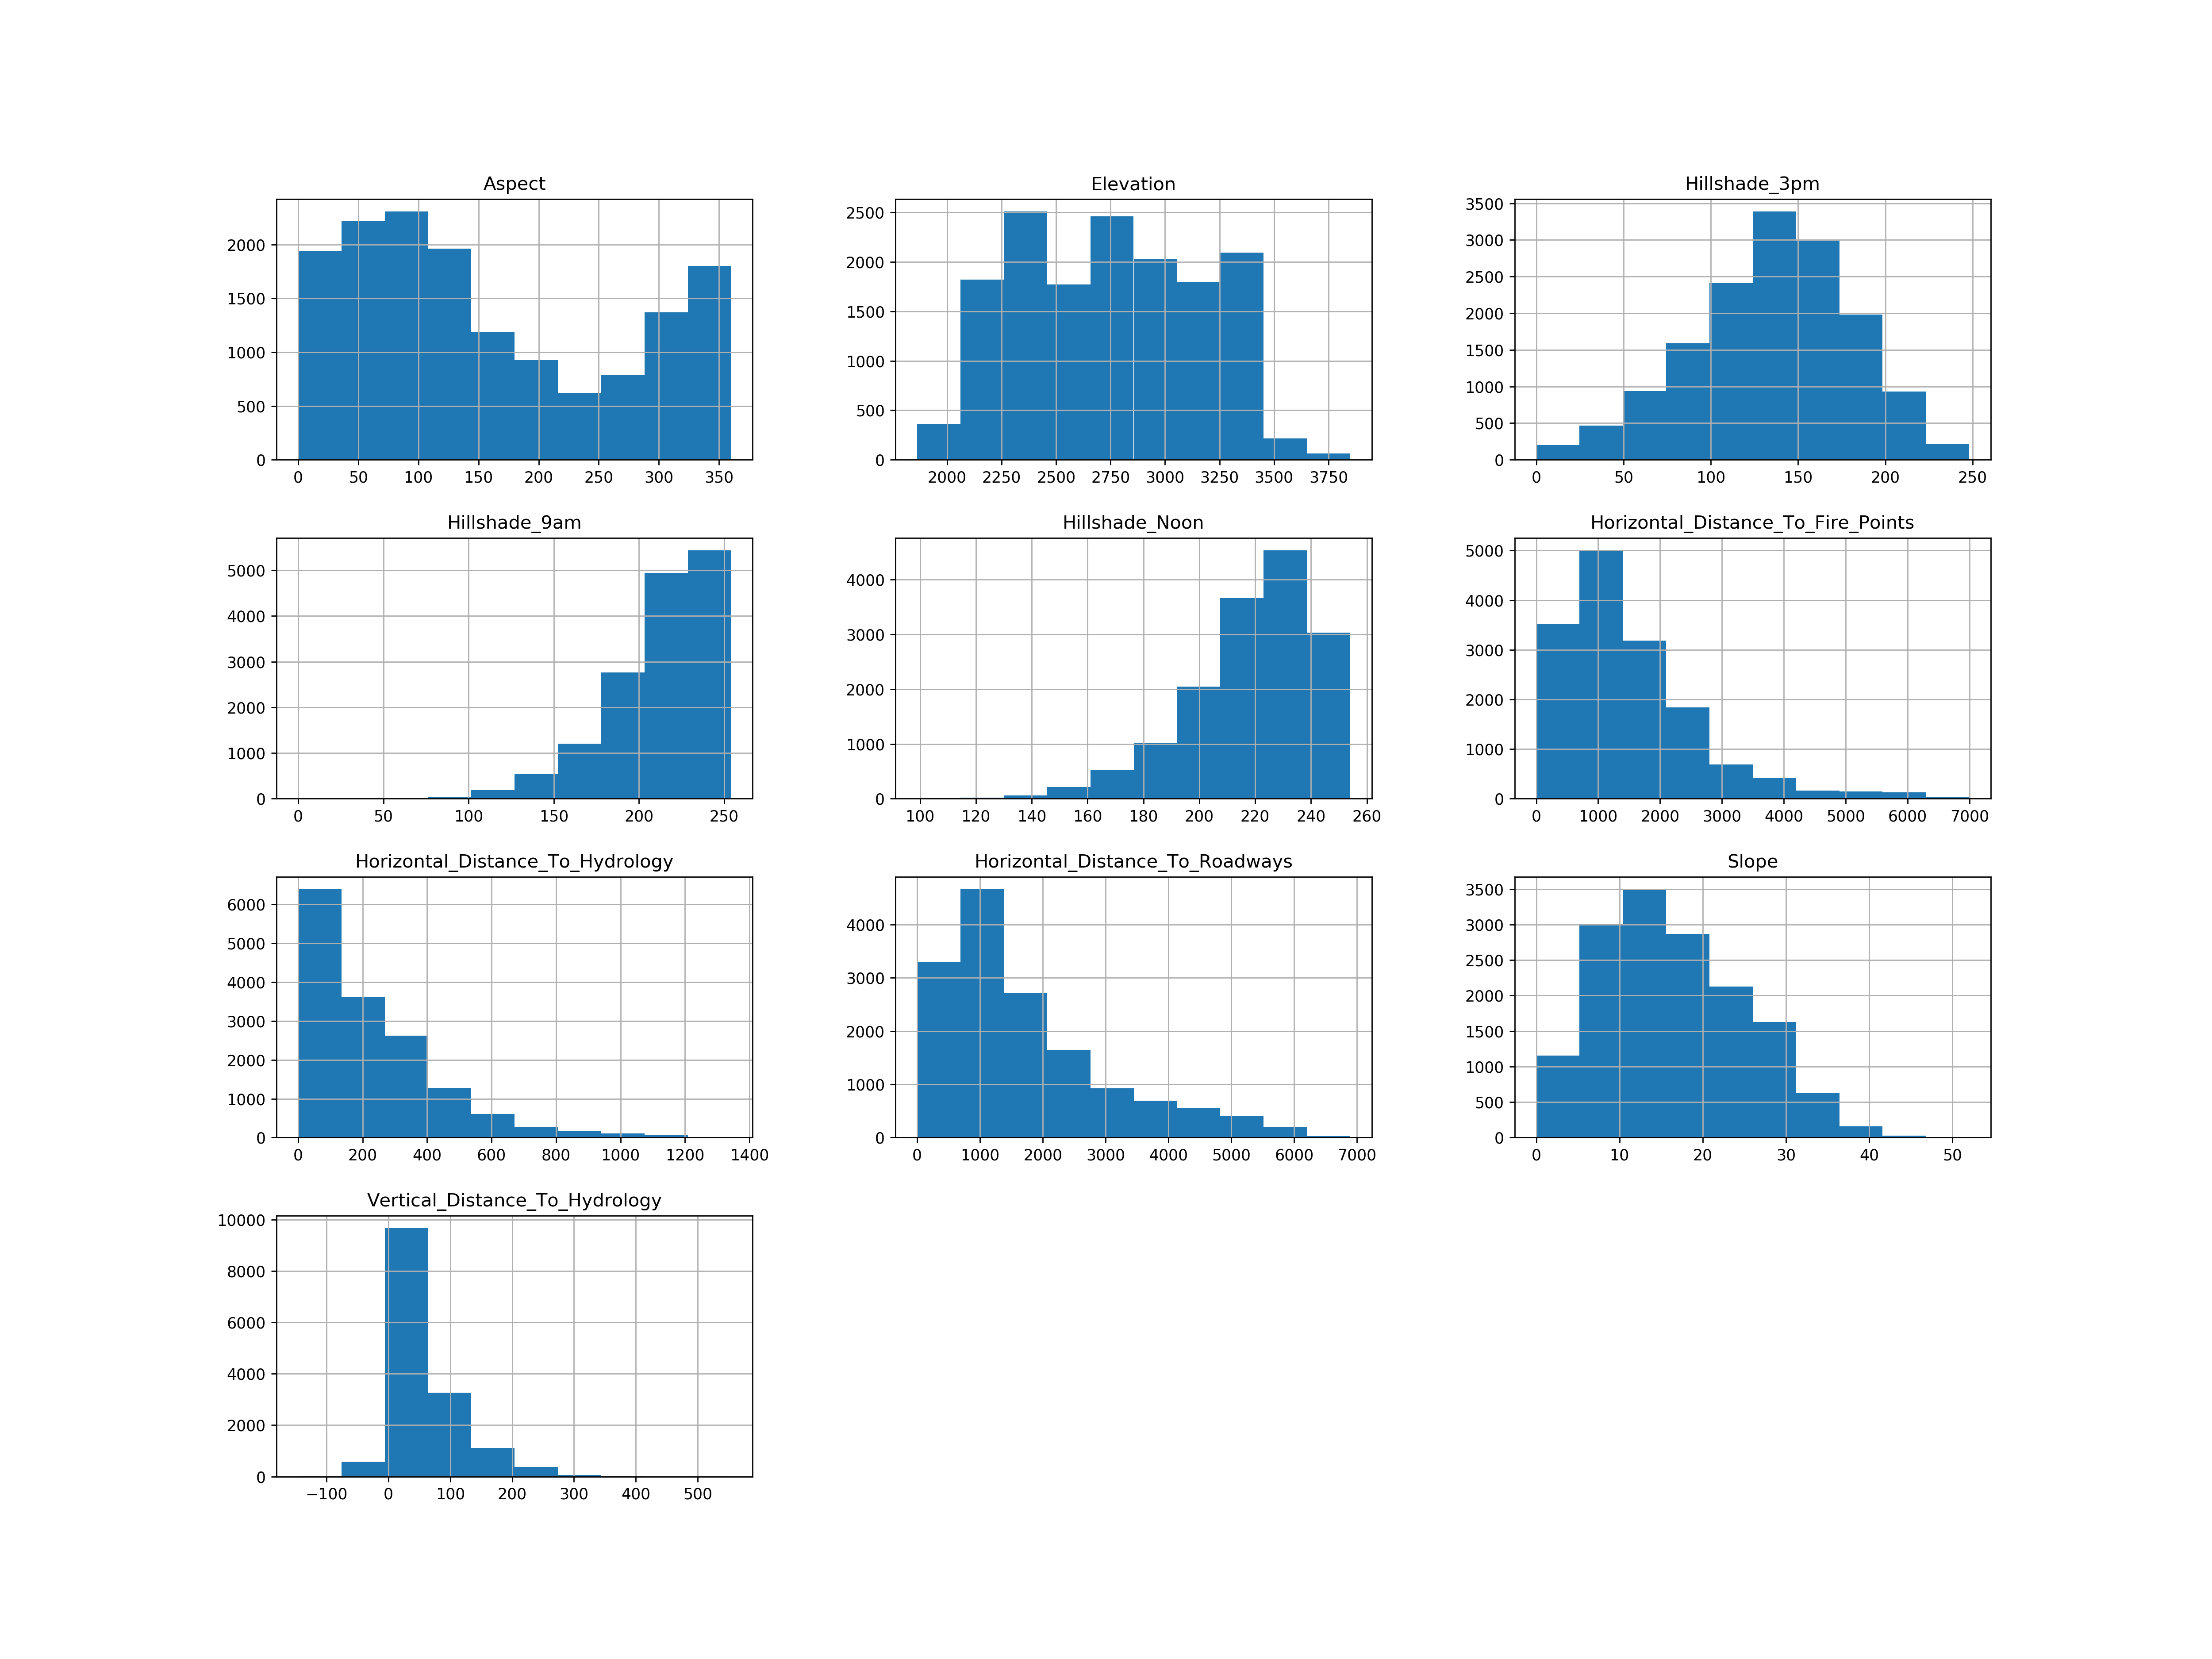

In [5]:
original_data.iloc[:,1:11].hist(figsize=(20,15))
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split (original_data, test_size=0.2, random_state=42)
X, y = train.drop('Cover_Type', axis=1), train['Cover_Type'].copy()
X_test, y_test = test.drop('Cover_Type', axis=1), test['Cover_Type'].copy()
X = X.drop(['Id', 'Soil_Type15', 'Soil_Type7'], axis=1) # drop these soil types because they're all 0

In [7]:
# No nulls, so do not need to deal with that.
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
trans_pipeline = Pipeline([
        ('imputer', Imputer(strategy='median')),
        ('std_scaler', StandardScaler())
])

X_cleaned = pd.DataFrame (trans_pipeline.fit_transform (X), columns = X.columns)

In [8]:
from sklearn.model_selection import RandomizedSearchCV

# X_Cleaned_and_transformed for X
def find_best_param_from_Rnd_Search (model, param_grid, scoring, X, y):
    rnd_search = RandomizedSearchCV(model, param_distributions=param_grid, cv=5, scoring=scoring)
    rnd_search.fit(X, y )
    return rnd_search.best_params_

acc = 'accuracy'

In [12]:
from sklearn.ensemble import RandomForestClassifier
rndf_clf = RandomForestClassifier(n_jobs=-1) # n_jobs=-1 indicates to use all available CPUs
rndf_param_grid = {
    'max_depth': [15, 20, 25], 'min_samples_leaf': [30, 35, 40],
    'max_leaf_nodes': [45, 50, 55], 'max_features': [20, 25, 30],
    'n_estimators': [100, 150, 200] 
    }
#'n_estimators': [300, 400, 500]   
rndf_clf_best_param = find_best_param_from_Rnd_Search (rndf_clf, rndf_param_grid, acc, X_cleaned, y)
rndf_clf_best_param

{'max_depth': 25,
 'max_features': 25,
 'max_leaf_nodes': 55,
 'min_samples_leaf': 40,
 'n_estimators': 150}

In [13]:
rndf_clf = RandomForestClassifier(n_jobs=-1, max_depth=25, max_features=25, max_leaf_nodes=55,
                                 min_samples_leaf=40, n_estimators=150)
rndf_clf.fit (X_cleaned, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features=25, max_leaf_nodes=55,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=40, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
#from sklearn.model_selection import cr
def clean_test (X_test):
    X_test_cleaned = X_test.drop(['Id', 'Soil_Type15', 'Soil_Type7'], axis=1)
    X_test_cleaned = trans_pipeline.transform (X_test_cleaned)
    return X_test_cleaned

X_test_cleaned = clean_test (X_test)
test_predict = rndf_clf.predict (X_test_cleaned)

In [21]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(test_predict, y_test)
# each row is the actual class, each column is the predicted class
print (conf_mx)

[[264 114   0   0   1   0  36]
 [ 60 220   1   0  28   1   1]
 [  0  10 273   7  19  78   0]
 [  0   0  46 436   0  36   0]
 [ 29  74  19   0 359  26   1]
 [  0   9  89   6   9 291   0]
 [ 68  11   0   0   0   0 402]]


In [23]:
''' Now to predict the final set without target labels '''
final_test_cleaned = clean_test (final_test_set)
final_test_predict = rndf_clf.predict (final_test_cleaned)

In [29]:
final_test_predict
final_predictions_df = pd.DataFrame ({
    'Id': final_test_set['Id'],
    'Cover_Type': final_test_predict
})
final_predictions_df = final_predictions_df.set_index ('Id')

In [31]:
final_predictions_df.to_csv ('test_predictions.csv')
final_predictions_df.head()

,Cover_Type
Id,
15121,2
15122,2
15123,2
15124,2
15125,2
